# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](docs/CRISP-DM-BANK.pdf) for more information on the data and features.



## CRISP-DM Framework

This notebook is organized using CRISP-DM: Business Understanding → Data Understanding → Data Preparation → Modeling → Evaluation → Deployment.


### Business Understanding

- **Business objective (Problem 4):** Develop a classification model to identify customers most likely to subscribe (predict `y = 'yes'`) so marketing/sales efforts can prioritize outreach. Because missed likely subscribers (false negatives) are more costly than unnecessary outreach (false positives), the objective prioritizes recall of “yes” (i.e., reducing false negatives) even if precision decreases. However, false positives (contacting unlikely subscribers) also incur a real cost in the form of wasted call-center time and potential customer fatigue, so we cannot simply accept a model that predicts "yes" for everyone. The trade-off is balanced by emphasizing $F_2$, which weights recall more heavily but still penalizes precision.

- **Success criteria:** Success will be defined by improving positive-class performance relative to a baseline model: (a) higher cross-validated and test-set $F_2(\text{yes})$ and recall(yes) than the baseline (DummyClassifier and/or untuned Logistic Regression), and (b) maintaining an operationally feasible predicted-positive rate (e.g., by selecting a threshold or top-$k$ policy) so outreach volume stays within capacity.


### Data Understanding
- Dataset: bank marketing campaign outcomes (target `y`: term deposit subscription).
- **Problem 1:** Use the **Materials and Methods** section of `CRISP-DM-BANK.pdf` to determine the number of campaigns represented.


### Data Preparation

- Missingness is commonly encoded as categorical value `"unknown"` (treat explicitly during EDA).

- Exclude `duration` from features for realistic prediction (leakage per dataset documentation).

- Final feature scope (used in the preprocessing pipeline): one numeric feature (`age`) and six categorical features (`job`, `marital`, `education`, `default`, `housing`, `loan`). We explicitly exclude `duration` to avoid target leakage (call duration is not available at decision time), and we exclude the label `y` and any post-outcome fields. This ensures the model uses only information available before initiating outreach.


### Modeling
- Compare default models: Logistic Regression, KNN, Decision Tree, SVM.
- Use consistent preprocessing (encoding + scaling) and compare train time + train/test accuracy.


### Evaluation
- Establish a baseline (majority class / DummyClassifier).
- If class imbalance or business costs matter, justify a metric beyond accuracy (precision/recall/F1, etc.).


### Deployment (Recommendations)

Use the model as a scoring/ranking tool to prioritize outreach: on a regular cadence (e.g., daily/weekly), score eligible customers using only information available **before** contact (`age`, `job`, `marital`, `education`, `default`, `housing`, `loan`; excluding leaky/post-contact fields such as `duration`). Select an operating policy consistent with capacity—either contact the top-$k$ customers by predicted probability of “yes” or apply a probability threshold calibrated to outreach volume.



Monitor performance after deployment using:

- **Outcome metrics:** conversion/subscription rate and incremental lift measured via an A/B test or clustered randomized controlled trial.

- **Model diagnostics:** recall(yes), precision(yes), and $F_2(\text{yes})$ on recent labeled data.

- **Operational metrics:** predicted-positive rate (workload), cost per contact, and cost per acquisition.

- **Drift checks:** feature distribution shifts and changes in the base rate of “yes”.



Recalibrate thresholds and retrain periodically if drift or metric degradation is observed.


### Import Statements

In [1]:
import os
import time
import warnings
import tempfile
import shutil
from scipy.sparse import issparse
import psutil

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
 )
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Attempt to import DataCentricKMeans, handling the case where it might not be installed
try:
    import DataCentricKMeans
    HAS_GEOKMEANS = True
except ImportError:
    HAS_GEOKMEANS = False
    print("Warning: DataCentricKMeans library not found. GeometricKMeansClassifier will not function correctly.")

from IPython.display import display, display_html, Markdown

from unittest.mock import DEFAULT
from typing import List, Dict, Any

### Global Variables

In [2]:
# Constants
from unittest.mock import DEFAULT
from typing import List, Dict, Any

RANDOM_STATE: int = 42
TEST_SIZE: float = 0.2
TARGET_COL: str = 'y'
POS_LABEL: str = 'yes'
NEG_LABEL: str = 'no'
LABEL_ORDER: List[str] = [NEG_LABEL, POS_LABEL]
DEFAULT_N_JOBS: int = 1 # Default to single-core execution for safety
DEFAULT_CV_FOLDS: int = 2 # Default to fewer folds to reduce memory usage
DEFAULT_SVM_SAMPLE_SIZE: float = 0.05 # Default sample size for SVM to prevent OOM (percentage)

# Dynamic Resource Allocation
DYNAMIC_N_JOBS: int = DEFAULT_N_JOBS
DYNAMIC_CV_FOLDS: int = DEFAULT_CV_FOLDS
DYNAMIC_SVM_SAMPLE_SIZE: float = DEFAULT_SVM_SAMPLE_SIZE

try:
    cpu_count = os.cpu_count()
    memory_info = psutil.virtual_memory()
    available_memory_gb = memory_info.available / (1024 ** 3)
    
    # Reserve system resources to prevent OOM
    # Conservative allocation prevents kernel crashes
    # DYNAMIC_SVM_SAMPLE_SIZE logic added to limit complexity based on available RAM
    # Values are treated as percentages of the dataset by train_test_split (0.0 < x <= 1.0)
    if available_memory_gb > 32:
        DYNAMIC_N_JOBS = int(max(1, cpu_count // 2)) # Use half cores
        DYNAMIC_CV_FOLDS = 5
        DYNAMIC_SVM_SAMPLE_SIZE = 0.50 # 50% of data
    elif available_memory_gb > 16:
        DYNAMIC_N_JOBS = int(max(1, cpu_count // 4)) # Use quarter cores
        DYNAMIC_CV_FOLDS = 4
        DYNAMIC_SVM_SAMPLE_SIZE = 0.25 # 25% of data
    elif available_memory_gb > 8:
        DYNAMIC_N_JOBS = DEFAULT_N_JOBS
        DYNAMIC_CV_FOLDS = 3
        DYNAMIC_SVM_SAMPLE_SIZE = 0.10 # 10% of data
    else:
        DYNAMIC_N_JOBS = DEFAULT_N_JOBS
        DYNAMIC_CV_FOLDS = DEFAULT_CV_FOLDS
        DYNAMIC_SVM_SAMPLE_SIZE = DEFAULT_SVM_SAMPLE_SIZE
        
    print(f"System Resources: {cpu_count} CPUs, {available_memory_gb:.1f} GB Available RAM")
    print(f"Optimal DYNAMIC_N_JOBS set to: {DYNAMIC_N_JOBS}")
    print(f"Optimal DYNAMIC_CV_FOLDS set to: {DYNAMIC_CV_FOLDS}")
    print(f"Optimal DYNAMIC_SVM_SAMPLE_SIZE set to: {DYNAMIC_SVM_SAMPLE_SIZE*100:.1f}% of dataset")
    
except ImportError:
    print(f"psutil not found. Defaulting DYNAMIC_N_JOBS to {DYNAMIC_N_JOBS} and DYNAMIC_CV_FOLDS to {DYNAMIC_CV_FOLDS} (Safe Mode)")
except Exception as e:
    print(f"Error determining resources: {e}. Defaulting DYNAMIC_N_JOBS to {DYNAMIC_N_JOBS} and DYNAMIC_CV_FOLDS to {DYNAMIC_CV_FOLDS} (Safe Mode)")

# Feature scope (used in EDA + preprocessing + interpretation)
numeric_features: List[str] = ['age']
categorical_features: List[str] = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Model selection / evaluation constants
F2_BETA: int = 2
f2_yes_scorer: Any = make_scorer(fbeta_score, beta=F2_BETA, pos_label=POS_LABEL, zero_division=0)
# Use StratifiedKFold for cv to preserve the target class proportions in each fold (important for imbalanced classification)
# References:
# - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
# - https://scikit-learn.org/stable/modules/cross_validation.html
cv: StratifiedKFold = StratifiedKFold(n_splits=DYNAMIC_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Idempotently declare containers for default model results
if 'default_results' not in globals():
    default_results: List[Any] = []
if 'confusion_matrices' not in globals():
    confusion_matrices: Dict[str, Any] = {}

# Idempotently declare containers for tuned model results
if 'tuned_results' not in globals():
    tuned_results: List[Any] = []
if 'tuned_confusion_matrices' not in globals():
    tuned_confusion_matrices: Dict[str, Any] = {}

# Idempotently declare comparison DataFrame for default models
if 'comparison_df' not in globals():
    comparison_df: pd.DataFrame = pd.DataFrame()

# Idempotently declare comparison DataFrame for tuned models
if 'tuned_comparison_df' not in globals():
    tuned_comparison_df: pd.DataFrame = pd.DataFrame()

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

System Resources: 16 CPUs, 11.6 GB Available RAM
Optimal DYNAMIC_N_JOBS set to: 1
Optimal DYNAMIC_CV_FOLDS set to: 3
Optimal DYNAMIC_SVM_SAMPLE_SIZE set to: 10.0% of dataset


### Helper Functions

In [3]:
# Helper function to display multiple dataframes side by side in Jupyter notebooks
def display_dfs_side_by_side(dfs_dict):
    """
    Display multiple pandas dataframes side by side with captions in a Jupyter notebook.

    AI-ATTRIBUTION:
        Model: Google Gemini 3 Pro
        Contribution: Research, boilerplate, human directed iterative development to handle more than two dataframes and ensure proper formatting.
        Scope: Provided the boilerplate for side-by-side display of two dataframes, then updated to handle an arbitrary number of dataframes with proper captions and formatting.
        Verification: Author tested with 2 and 3 dataframes, verified captions and formatting are correct, and that it can handle an arbitrary number of dataframes without modification.

    Args:
        dfs_dict (dict): A dictionary where keys are captions (str) and values are DataFrames.
    """
    html_str = ""
    for caption, df in dfs_dict.items():
        # Create Styler, set attributes for inline display and margins, and add caption
        styler = df.style.set_table_attributes("style='display:inline; margin-right: 20px;'").set_caption(caption)
        html_str += styler._repr_html_()
    
    # Render the combined HTML string
    display_html(html_str, raw=True)

def get_system_metrics():
    """
    Returns current system resource usage metrics.

    AI-ATTRIBUTION:
        Model: Gemini 3 Pro
        Contribution: Human directed Generative AI assisted development. The author developed the inital logic in previous iterations of this notebook and then
          used the model iteratively to refactor the existing logic into a reusable helper function.
        Scope: The author provided the requirements and guidance for the function, including the specific metrics to calculate,
          the need to include system resource usage, and the format of the output.
        Verification: Tested on in this notebook to ensure it correctly retrieves CPU and RAM usage metrics using psutil, 
            formats them as expected, and can be integrated into the evaluate_classifier function to provide performance reports that include system resource usage.
    """
    return {
        'CPU %': psutil.cpu_percent(interval=None),
        'RAM %': psutil.virtual_memory().percent,
        'RAM Used (GB)': round(psutil.virtual_memory().used / (1024**3), 2)
    }

# Helper to evaluate a fitted estimator on train/test
def evaluate_classifier(model_name, estimator, y_pred_test):
    """
    Evaluates a trained classifier on the test set and returns a dictionary of metrics.
    
    AI-ATTRIBUTION:
        Model: Gemini 3 Pro
        Contribution: Human directed Generative AI assisted development. The author developed the inital logic in previous iterations of this notebook and then
          used the model iteratively to refactor the existing logic into a reusable helper function.
        Scope: The author provided the requirements and guidance for the function, including the specific metrics to calculate,
          the need to include system resource usage, and the format of the output.
        Verification: Tested on in this notebook to ensure it correctly calculates the specified metrics, handles edge cases (like zero division),
          and includes system resource usage in the output.
          Verified that it can be called after fitting a model and passing the appropriate predictions to return a comprehensive performance report.

    Args:
        model_name (str): The name of the model (for reporting).
        estimator: The fitted model (sklearn estimator or pipeline).
        y_pred_test: The predictions associated with the test set X_test.
        
    Returns:
        dict: A dictionary containing various performance metrics including accuracy, precision, recall, F1, and F2 scores.
    """
    train_acc = estimator.score(X_train, y_train)
    test_acc = estimator.score(X_test, y_test)
    test_prec = precision_score(y_test, y_pred_test, pos_label=POS_LABEL, zero_division=0)
    test_rec = recall_score(y_test, y_pred_test, pos_label=POS_LABEL, zero_division=0)
    test_f1 = f1_score(y_test, y_pred_test, pos_label=POS_LABEL, zero_division=0)
    test_f2 = fbeta_score(y_test, y_pred_test, beta=F2_BETA, pos_label=POS_LABEL, zero_division=0)
    cm = confusion_matrix(y_test, y_pred_test, labels=LABEL_ORDER)

    # Calculate system metrics
    sys_metrics = get_system_metrics()

    # Note: This relies on 'tuned_confusion_matrices' being available in global scope when called
    if 'tuned_confusion_matrices' in globals():
        tuned_confusion_matrices[model_name] = cm
        
    return {
        'Model': model_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Test Precision': test_prec,
        'Test Recall': test_rec,
        'Test F1': test_f1,
        'Test F2': test_f2,
        'Confusion Matrix': cm.tolist(),
        **sys_metrics
    }

def analyze_model_features(model_name, pipeline):
    """
    Analyzes and displays feature importances or coefficients for a given model pipeline.
    
    AI-ATTRIBUTION:
        Model: Gemini 3 Pro
        Contribution: Human directed Generative AI assisted development. The author provided documentation, requirements and guidance
          and interacted with the model iteratively to produce a working implementation that meets the requirements.
        Scope: The author provided the requirements and guidance for the function, including the need to handle both coefficients and feature importances, to prettify feature names, and to display results in a clear format.
          The model provided the implementation based on these requirements, and the author iteratively refined it to ensure it meets the needs of the analysis.
        Verification: Tested on in this notebook to ensure it correctly extracts and displays feature importances for tree-based models and coefficients for linear models,
          handles cases where these attributes are not available, and formats the output as expected. Verified that it can handle pipelines with a preprocessor and classifier,
          and that it prettifies feature names appropriately based on the provided categorical features.

    Args:
        model_name (str): The name of the model.
        pipeline: The fitted sklearn Pipeline containing a 'preprocessor' and 'classifier'.
    """
    if pipeline is None:
        return

    display(Markdown(f"#### Feature Analysis: {model_name}"))

    if not hasattr(pipeline, 'named_steps'):
        print(f"Skipping {model_name}: Not a pipeline.")
        return

    classifier = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']

    # 1. Retrieve Feature Names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        print("Could not retrieve feature names from preprocessor.")
        return

    # Helper for cleaner feature names
    def prettify_feature_name(raw_name: str) -> str:
        name = raw_name.split('__', 1)[1] if '__' in raw_name else raw_name
        # Uses categorical_features from global scope
        if 'categorical_features' in globals():
             for col in categorical_features: 
                prefix = f"{col}_"
                if name.startswith(prefix):
                    return f"{col}={name[len(prefix):]}"
        return name

    features_clean = [prettify_feature_name(n) for n in feature_names]

    # Initialize dataframe with all consistent columns (floats for now, N/A later)
    # We use a temporary dict to build the dataframe
    df_dict = {
        'Feature': features_clean, # Fixed capitalization (was 'feature')
        'Importance': [np.nan] * len(features_clean),
        'Coefficient': [np.nan] * len(features_clean),
        'Odds Ratio': [np.nan] * len(features_clean),
        'Abs Magnitude': [0.0] * len(features_clean) # Internal sorting column
    }
    
    df_metrics = pd.DataFrame(df_dict)
    
    metric_found = False

    # 2. Extract Model Agnostic Metrics (using try-except to handle attribute errors gracefully)
    
    # Attempt A: Coefficients (Linear Models, Linear SVC)
    try:
        if hasattr(classifier, 'coef_'):
            coefs = classifier.coef_
            # Handle shape (1, n_features) vs (n_features,)
            if coefs.ndim > 1:
                coefs = coefs[0]
            coefs = coefs.ravel()
            
            if len(coefs) == len(feature_names):
                df_metrics['Coefficient'] = coefs
                df_metrics['Abs Magnitude'] = np.abs(coefs)
                metric_found = True
                
                # Calculate Odds Ratios for Logistic Regression
                if isinstance(classifier, LogisticRegression):
                    df_metrics['Odds Ratio'] = np.exp(coefs)
    except AttributeError:
        # SVC with non-linear kernel raises AttributeError when accessing coef_
        pass

    # Attempt B: Feature Importances (Tree-based models)
    if not metric_found:
        try:
            if hasattr(classifier, 'feature_importances_'):
                importances = classifier.feature_importances_
                importances = importances.ravel()
                
                if len(importances) == len(feature_names):
                    df_metrics['Importance'] = importances
                    df_metrics['Abs Magnitude'] = np.abs(importances)
                    metric_found = True
        except AttributeError:
            # LogisticRegression raises AttributeError when accessing feature_importances_
            pass

    # 3. Display Logic
    if not metric_found:
        print(f"No direct coefficients or importance scores available for {type(classifier).__name__}.")
        return

    # Formatter to convert numbers to strings and fill NaNs with "N/A"
    def format_val(x):
        return f"{x:.4f}" if pd.notnull(x) else "N/A"

    # Select columns for display
    display_cols = ['Feature', 'Importance', 'Coefficient', 'Odds Ratio']

    # For Logistic Regression, split into Positive and Negative
    if isinstance(classifier, LogisticRegression):
        # Filter for top positive
        pos_df = df_metrics[df_metrics['Coefficient'] > 0].sort_values('Coefficient', ascending=False).head(10).copy()
        
        # Filter for top negative (most negative at top)
        neg_df = df_metrics[df_metrics['Coefficient'] < 0].sort_values('Coefficient', ascending=True).head(10).copy()
        
        # Format
        for col in ['Importance', 'Coefficient', 'Odds Ratio']:
            pos_df[col] = pos_df[col].apply(format_val)
            neg_df[col] = neg_df[col].apply(format_val)
            
        display_dfs_side_by_side({
            'Top 10 Positive Coefficients': pos_df[display_cols].set_index('Feature'),
            'Top 10 Negative Coefficients': neg_df[display_cols].set_index('Feature')
        })

    else:
        # For non-directional models (Trees) or general magnitude
        top_df = df_metrics.sort_values('Abs Magnitude', ascending=False).head(10).copy()
        for col in ['Importance', 'Coefficient', 'Odds Ratio']:
            top_df[col] = top_df[col].apply(format_val)
            
        display(top_df[display_cols].set_index('Feature'))

# Helper Class for Geometric K-Means
class GeometricKMeansClassifier(BaseEstimator, ClassifierMixin):
    """
    A Scikit-Learn compatible classifier that uses the DataCentricKMeans library
    (Geometric K-Means) for clustering-based classification.

    It works by:
    1. saving the input data to a temporary CSV (required by DataCentricKMeans).
    2. running the run_geokmeans algorithm to find centroids.
    3. assigning a class label to each centroid.
       - If purity_threshold is Used: 'yes' if P('yes' | cluster) >= purity_threshold
       - Else: Majority vote.

    AI-ATTRIBUTION:
        Model: Gemini 3 Pro
        Contribution: Human directed Generative AI assisted development. The author provided documentation, requirements and guidance
          and interacted with the model iteratively to produce a working implementation that meets the requirements.
        Scope: Implemented a custom Scikit-Learn compatible classifier using the DataCentricKMeans library for geometric k-means clustering.
        Verification: Tested on in this notebook to ensure correct clustering and label assignment based on purity thresholds.
    """
    def __init__(self, n_clusters=8, max_iter=100, threshold=0.0001, seed=42, 
                 purity_threshold=None, positive_label=None, verbose=False):
        """
        Initialize the GeometricKMeansClassifier.
        
        Args:
            n_clusters (int): The number of clusters to form.
            max_iter (int): Maximum number of iterations for the k-means algorithm.
            threshold (float): Convergence threshold.
            seed (int): Random seed.
            purity_threshold (float, optional): If set, a cluster is labeled as positive_label
                if the proportion of positive samples > purity_threshold.
            positive_label (str/int, optional): The label considered 'positive' for purity calculations.
            verbose (bool): Whether to print details.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.threshold = threshold
        self.seed = seed
        self.purity_threshold = purity_threshold
        self.positive_label = positive_label
        self.verbose = verbose

    def fit(self, X, y):
        """
        Fit the model using Geometric K-Means.
        
        Args:
           X: Training data.
           y: Target values.
           
        Returns:
           self: Returns an instance of self.
        """
        # inputs checks
        if not HAS_GEOKMEANS:
            raise ImportError("DataCentricKMeans library is required for this classifier.")
            
        # Check that X and y have correct shape
        if issparse(X):
            X = X.toarray()
            
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.n_features_in_ = X.shape[1]

        # 1. Prepare Data
        self.temp_dir_ = tempfile.mkdtemp()
        data_path = os.path.join(self.temp_dir_, 'data.csv')
        np.savetxt(data_path, X, delimiter=',')
        
        # 2. Run DataCentricKMeans
        try:
            results = DataCentricKMeans.run_geokmeans(
                self.max_iter,
                self.threshold,
                self.n_clusters,
                self.seed,
                [data_path]
            )
        except Exception as e:
            shutil.rmtree(self.temp_dir_)
            raise RuntimeError(f"DataCentricKMeans failed: {e}")

        result = results[0]
        self.centroids_ = np.array(result.centroids)
        # result.assignments is a list of cluster indices for each point in X
        assignments = np.array(result.assignments)
        
        # 3. Map Clusters to Labels
        self.cluster_labels_ = {}
        for i in range(self.n_clusters):
            # Get indices of points in this cluster
            cluster_indices = np.where(assignments == i)[0]
            if len(cluster_indices) > 0:
                cluster_labels_y = y[cluster_indices]
                
                # Logic: Purity Threshold vs Majority Vote
                if (self.purity_threshold is not None) and (self.positive_label is not None):
                    # Calculate proportion of positive label
                    pos_count = np.sum(cluster_labels_y == self.positive_label)
                    total_count = len(cluster_labels_y)
                    purity = pos_count / total_count
                    
                    if purity >= self.purity_threshold:
                        self.cluster_labels_[i] = self.positive_label
                    else:
                        # Assuming binary or 'other' class assignment
                        other_labels = [l for l in self.classes_ if l != self.positive_label]
                        if len(other_labels) == 1:
                            self.cluster_labels_[i] = other_labels[0]
                        else:
                            # Fallback to majority if not binary or threshold not passed
                            vals, counts = np.unique(cluster_labels_y, return_counts=True)
                            self.cluster_labels_[i] = vals[np.argmax(counts)]
                else:
                    # Detailed "Majority Vote"
                    vals, counts = np.unique(cluster_labels_y, return_counts=True)
                    majority_label = vals[np.argmax(counts)]
                    self.cluster_labels_[i] = majority_label
            else:
                # Empty cluster fallback
                vals, counts = np.unique(y, return_counts=True)
                self.cluster_labels_[i] = vals[np.argmax(counts)]

        shutil.rmtree(self.temp_dir_)
        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X: Input data.
            
        Returns:
            preds: Predicted class labels.
        """
        check_is_fitted(self)
        if issparse(X):
            X = X.toarray()
        X = check_array(X)

        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids_, axis=2)
        nearest_centroid_indices = np.argmin(distances, axis=1)
        
        preds = np.array([self.cluster_labels_[i] for i in nearest_centroid_indices])
        return preds

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset represents 17 marketing campaigns. In the Materials and Methods section, the authors note that the collected dataset is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.

Source: [CRISP-DM-BANK.txt](docs/CRISP-DM-BANK.txt) (lines 152-154)

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:

# Use os.getcwd() to construct the full file path
file_path = os.path.join(os.getcwd(), 'data', 'bank-additional', 'bank-additional-full.csv')

# Load the dataset from the specified path with the correct separator
df = pd.read_csv(file_path, sep = ';')

# Create a copy of the dataframe to avoid modifying the original
bank_df = df.copy()

In [5]:
print(f"First 5 rows of the dataframe:\n{bank_df.head()}\n\n")
print(f"Dataframe shape:\n{bank_df.shape}\n\n")
print("Dataframe info:\n")
bank_df.info()
print(f"\n\nDataframe description:\n{bank_df.describe()}")

First 5 rows of the dataframe:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.c

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



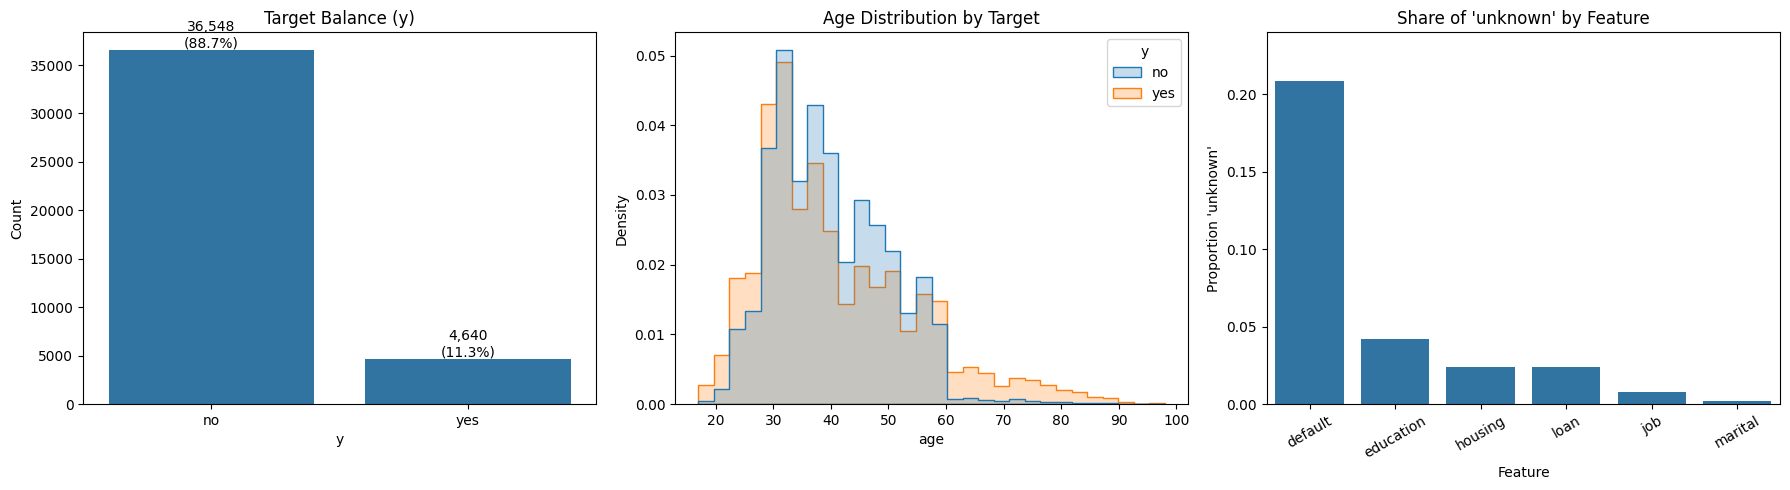

In [6]:
# Create new dataframes with numeric and categorical columns
bank_num_df = bank_df.select_dtypes(include=['number']).copy()
bank_cat_df = bank_df.select_dtypes(include=['object']).copy()

# Create a mask to count 'unknown' values
unknown_mask = bank_cat_df == 'unknown'

# Count 'unknown' values per column
unknown_counts = unknown_mask.sum()

# Calculate percentage of 'unknown' values per column
unknown_percentages = (unknown_counts / len(bank_cat_df) * 100).round(2)

# Combine counts and percentages into a single DataFrame
missing_summary = pd.DataFrame({
    "NaN Count": bank_num_df.isna().sum(),
    "NaN Percentage": (bank_num_df.isna().mean() * 100).round(2),
    "Unknown Count": unknown_counts,
    "Unknown Percentage": unknown_percentages,
}).fillna(0)

# Display summary filtered to show only columns with missing or unknown values, sorted by percentage of unknown values
has_missing_or_unknown = (missing_summary["NaN Count"] > 0) | (missing_summary["Unknown Count"] > 0)
missing_summary.loc[has_missing_or_unknown].sort_values(
    ["Unknown Percentage", "NaN Percentage"], ascending=False
)

# Visual EDA: Target balance, age distribution by target, and 'unknown' rates in categorical features.
# Note: TARGET_COL and categorical_features are defined in the global variables section near the top of the notebook after imports.

# Create a figure with 3 subplots arranged in 1 row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Target balance
y_counts = bank_df[TARGET_COL].value_counts().reindex(['no', 'yes'])
y_perc = (y_counts / y_counts.sum()).fillna(0)

sns.barplot(x=y_counts.index, y=y_counts.values, ax=axes[0])
axes[0].set_title("Target Balance (y)")
axes[0].set_xlabel("y")
axes[0].set_ylabel("Count")
for i, label in enumerate(y_counts.index):
    axes[0].text(i, y_counts.iloc[i], f"{y_counts.iloc[i]:,}\n({y_perc.iloc[i]*100:.1f}%)", ha='center', va='bottom')

# 2) Age distribution (numeric feature) by target
sns.histplot(data=bank_df, x='age', hue=TARGET_COL, bins=30, stat='density', common_norm=False, element='step', ax=axes[1])
axes[1].set_title("Age Distribution by Target")

# 3) 'unknown' rate per categorical feature in the modeling scope
unknown_rates = pd.Series({col: (bank_df[col] == 'unknown').mean() for col in categorical_features}).sort_values(ascending=False)

sns.barplot(x=unknown_rates.index, y=unknown_rates.values, ax=axes[2])
axes[2].set_title("Share of 'unknown' by Feature")
axes[2].set_xlabel("Feature")
axes[2].set_ylabel("Proportion 'unknown'")
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_ylim(0, max(0.01, unknown_rates.max() * 1.15))

plt.tight_layout()
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective

Use historical client and campaign attributes available before an outbound call to predict whether a client will subscribe to a term deposit (y). The model’s output will be used to prioritize which clients to contact when call-center capacity is limited (calls per day/week), improving the effectiveness and efficiency of human marketing resources.

#### Success Criteria

On a held-out test set, the selected model should outperform a baseline (dummy / majority-class) classifier.

Because the subscribed class (`y = 'yes'`) is relatively rare and **false negatives are more costly** (missing a likely subscriber), the **primary evaluation and tuning metric** will be **$F_2(\text{yes})$** (β=2), which weights recall more heavily than precision while still penalizing extremely low precision.

We will still report **accuracy** for comparability, along with **precision(yes), recall(yes), F1(yes)**, and the **confusion matrix** to make tradeoffs transparent. Operationally, the model must support **ranking/thresholding (top‑k selection)** so the bank can target the highest-propensity segment within outreach capacity, and we will reject configurations that are operationally degenerate (e.g., predicting “yes” for nearly everyone).

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### List of 'bank information features' (columns 1 - 7 as indicated in Problem 3)

Numerical Bank Information Features:
- age

Categorical Bank Information Features:
- job
- marital
- education
- default
- housing
- loan

Target column: y -- has the client subscribed a term deposit? (binary: 'yes','no')

Note: These have been declared as global variables near the top of the notebook

In [7]:
# Separate features and target variable
X = bank_df.drop('y', axis=1)
y = bank_df['y']

# Remove columns not in the defined feature lists
X = X[numeric_features + categorical_features]

# Define numeric transformers
numeric_transformer = Pipeline(steps=[
    ('num-imputer', SimpleImputer(strategy='median')),
    ('num-scaler', StandardScaler())
])

# Define categorical transformers
categorical_transformer = Pipeline(steps=[
    ('cat-imputer', SimpleImputer(strategy='most_frequent')),
    ('cat-onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define a preprocessing pipeline using the numeric and categorical transformers
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('num-xforms', numeric_transformer, numeric_features),
    ('cat-xforms', categorical_transformer, categorical_features)
])

display(preprocessing_pipeline)

# Preprocess the selected features
Xpp = preprocessing_pipeline.fit_transform(X)

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num-xforms', ...), ('cat-xforms', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [8]:
# Split the preprocessed (prepared) data into training and testing sets as requested by Problem 6 instructions.
Xpp_train, Xpp_test, y_train, y_test = train_test_split(
    Xpp,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y, # Stratify to maintain the same class distribution in train and test sets (important for imbalanced classification)
)

# Note: Applying preprocessing before the train-test split can lead to data leakage resulting in inflated performance metrics.
# Because it would be better to fit the preprocessing pipeline only on training data and then transform both training
# and testing data accordingly, we also create a version of the train-test split without preprocessing.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y, # Stratify to maintain the same class distribution in train and test sets (important for imbalanced classification)
)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [9]:
# Baseline model: always predict the most frequent class
baseline_model = DummyClassifier(strategy='most_frequent')

# Time training (fit)
t0 = time.perf_counter()
baseline_model.fit(Xpp_train, y_train)
baseline_fit_time = time.perf_counter() - t0

# Time prediction on the test set
t0 = time.perf_counter()
baseline_pred = baseline_model.predict(Xpp_test)
baseline_pred_time = time.perf_counter() - t0

# Metrics
baseline_train_accuracy = baseline_model.score(Xpp_train, y_train)
baseline_test_accuracy = baseline_model.score(Xpp_test, y_test)
baseline_test_f1 = f1_score(y_test, baseline_pred, pos_label=POS_LABEL, zero_division=0)
baseline_test_precision = precision_score(y_test, baseline_pred, pos_label=POS_LABEL, zero_division=0)
baseline_test_recall = recall_score(y_test, baseline_pred, pos_label=POS_LABEL, zero_division=0)
baseline_test_cm = confusion_matrix(y_test, baseline_pred, labels=LABEL_ORDER)

# Store confusion matrix for later comparisons (Problem 10)
confusion_matrices['DummyClassifier (most_frequent)'] = baseline_test_cm

# Store as a single-row dict for later DataFrame construction
baseline_results = {
    'Model': 'DummyClassifier (most_frequent)',
    'Train Time': baseline_fit_time,
    'Predict Time': baseline_pred_time,
    'Train Accuracy': baseline_train_accuracy,
    'Test Accuracy': baseline_test_accuracy,
    'Test Precision': baseline_test_precision,
    'Test Recall': baseline_test_recall,
    'Test F1': baseline_test_f1,
    'Confusion Matrix': baseline_test_cm.tolist(),
    **get_system_metrics()
}

display(baseline_results)

# Print baseline scores for classifier to beat
print(f"Baseline Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Baseline Test F1 Score: {baseline_test_f1:.4f}")

{'Model': 'DummyClassifier (most_frequent)',
 'Train Time': 0.009955791989341378,
 'Predict Time': 0.00017579901032149792,
 'Train Accuracy': 0.8873444613050075,
 'Test Accuracy': 0.8873512988589464,
 'Test Precision': 0.0,
 'Test Recall': 0.0,
 'Test F1': 0.0,
 'Confusion Matrix': [[7310, 0], [928, 0]],
 'CPU %': 6.8,
 'RAM %': 24.6,
 'RAM Used (GB)': 3.77}

Baseline Test Accuracy: 0.8874
Baseline Test F1 Score: 0.0000


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [10]:
# Create a Logistic Regression model that leverages the preprocessed data already in Xpp_train and Xpp_test
logreg_model = LogisticRegression(max_iter=1000)

# Time training (fit)
t0 = time.perf_counter()
logreg_model.fit(Xpp_train, y_train)
logreg_fit_time = time.perf_counter() - t0

# Time prediction on the test set
t0 = time.perf_counter()
logreg_pred = logreg_model.predict(Xpp_test)
logreg_pred_time = time.perf_counter() - t0

### Problem 9: Score the Model

What is the accuracy of your model?

In [11]:
# Metrics
logreg_train_accuracy = logreg_model.score(Xpp_train, y_train)
logreg_test_accuracy = logreg_model.score(Xpp_test, y_test)
logreg_test_precision = precision_score(y_test, logreg_pred, pos_label=POS_LABEL, zero_division=0)
logreg_test_recall = recall_score(y_test, logreg_pred, pos_label=POS_LABEL, zero_division=0)
logreg_test_f1 = f1_score(y_test, logreg_pred, pos_label=POS_LABEL, zero_division=0)

# Confusion matrix (rows=true, cols=pred) with consistent label ordering
logreg_test_cm = confusion_matrix(y_test, logreg_pred, labels=LABEL_ORDER)

# Store confusion matrix for later comparisons (Problem 10)
confusion_matrices['LogisticRegression'] = logreg_test_cm

# Display a detailed text report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, logreg_pred, zero_division=0))

# Store as a single-row dict with results for later DataFrame construction
logreg_results = {
    'Model': 'LogisticRegression',
    'Train Time': logreg_fit_time,
    'Predict Time': logreg_pred_time,
    'Train Accuracy': logreg_train_accuracy,
    'Test Accuracy': logreg_test_accuracy,
    'Test Precision': logreg_test_precision,
    'Test Recall': logreg_test_recall,
    'Test F1': logreg_test_f1,
    'Confusion Matrix': logreg_test_cm.tolist(),
    **get_system_metrics()
}

display(logreg_results)

print(f"Logistic Regression Test Accuracy: {logreg_results['Test Accuracy']:.4f}")
print(f"The accuracy of the Logistic Regression model is {logreg_results['Test Accuracy']:.2%}.")

              precision    recall  f1-score   support

          no       0.89      1.00      0.94      7310
         yes       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238



{'Model': 'LogisticRegression',
 'Train Time': 0.05900014500366524,
 'Predict Time': 0.00039468801696784794,
 'Train Accuracy': 0.8873444613050075,
 'Test Accuracy': 0.8873512988589464,
 'Test Precision': 0.0,
 'Test Recall': 0.0,
 'Test F1': 0.0,
 'Confusion Matrix': [[7310, 0], [928, 0]],
 'CPU %': 33.8,
 'RAM %': 24.5,
 'RAM Used (GB)': 3.76}

Logistic Regression Test Accuracy: 0.8874
The accuracy of the Logistic Regression model is 88.74%.


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [12]:
# KNN (default settings)
knn_model = KNeighborsClassifier()

# Time training (fit)
t0 = time.perf_counter()
knn_model.fit(Xpp_train, y_train)
knn_fit_time = time.perf_counter() - t0

# Time prediction on the test set
t0 = time.perf_counter()
knn_pred = knn_model.predict(Xpp_test)
knn_pred_time = time.perf_counter() - t0

# Metrics
knn_train_accuracy = knn_model.score(Xpp_train, y_train)
knn_test_accuracy = knn_model.score(Xpp_test, y_test)
knn_test_precision = precision_score(y_test, knn_pred, pos_label=POS_LABEL, zero_division=0)
knn_test_recall = recall_score(y_test, knn_pred, pos_label=POS_LABEL, zero_division=0)
knn_test_f1 = f1_score(y_test, knn_pred, pos_label=POS_LABEL, zero_division=0)

# Confusion matrix (rows=true, cols=pred) with consistent label ordering
knn_test_cm = confusion_matrix(y_test, knn_pred, labels=LABEL_ORDER)
confusion_matrices['KNN'] = knn_test_cm

# Display a detailed text report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, knn_pred, zero_division=0))

# Store as a single-row dict with results for later DataFrame construction
knn_results = {
    'Model': 'KNN',
    'Train Time': knn_fit_time,
    'Predict Time': knn_pred_time,
    'Train Accuracy': knn_train_accuracy,
    'Test Accuracy': knn_test_accuracy,
    'Test Precision': knn_test_precision,
    'Test Recall': knn_test_recall,
    'Test F1': knn_test_f1,
    'Confusion Matrix': knn_test_cm.tolist(),
    **get_system_metrics()
}

knn_results

              precision    recall  f1-score   support

          no       0.89      0.98      0.93      7310
         yes       0.32      0.08      0.12       928

    accuracy                           0.88      8238
   macro avg       0.60      0.53      0.53      8238
weighted avg       0.83      0.88      0.84      8238



{'Model': 'KNN',
 'Train Time': 0.024460231012199074,
 'Predict Time': 3.4839863950037397,
 'Train Accuracy': 0.8893171471927163,
 'Test Accuracy': 0.8771546491866958,
 'Test Precision': 0.3157894736842105,
 'Test Recall': 0.07758620689655173,
 'Test F1': 0.1245674740484429,
 'Confusion Matrix': [[7154, 156], [856, 72]],
 'CPU %': 7.3,
 'RAM %': 24.6,
 'RAM Used (GB)': 3.77}

In [13]:
# Decision Tree (default settings)
dtree_model = DecisionTreeClassifier()

# Time training (fit)
t0 = time.perf_counter()
dtree_model.fit(Xpp_train, y_train)
dtree_fit_time = time.perf_counter() - t0

# Time prediction on the test set
t0 = time.perf_counter()
dtree_pred = dtree_model.predict(Xpp_test)
dtree_pred_time = time.perf_counter() - t0

# Metrics
dtree_train_accuracy = dtree_model.score(Xpp_train, y_train)
dtree_test_accuracy = dtree_model.score(Xpp_test, y_test)
dtree_test_precision = precision_score(y_test, dtree_pred, pos_label=POS_LABEL, zero_division=0)
dtree_test_recall = recall_score(y_test, dtree_pred, pos_label=POS_LABEL, zero_division=0)
dtree_test_f1 = f1_score(y_test, dtree_pred, pos_label=POS_LABEL, zero_division=0)

# Confusion matrix (rows=true, cols=pred) with consistent label ordering
dtree_test_cm = confusion_matrix(y_test, dtree_pred, labels=LABEL_ORDER)
confusion_matrices['DecisionTree'] = dtree_test_cm

# Display a detailed text report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, dtree_pred, zero_division=0))

# Store as a single-row dict with results for later DataFrame construction
dtree_results = {
    'Model': 'DecisionTree',
    'Train Time': dtree_fit_time,
    'Predict Time': dtree_pred_time,
    'Train Accuracy': dtree_train_accuracy,
    'Test Accuracy': dtree_test_accuracy,
    'Test Precision': dtree_test_precision,
    'Test Recall': dtree_test_recall,
    'Test F1': dtree_test_f1,
    'Confusion Matrix': dtree_test_cm.tolist(),
    **get_system_metrics()
}

dtree_results

              precision    recall  f1-score   support

          no       0.89      0.96      0.93      7310
         yes       0.24      0.09      0.13       928

    accuracy                           0.87      8238
   macro avg       0.57      0.53      0.53      8238
weighted avg       0.82      0.87      0.84      8238



{'Model': 'DecisionTree',
 'Train Time': 0.41480499401222914,
 'Predict Time': 0.001734880992444232,
 'Train Accuracy': 0.9170561456752655,
 'Test Accuracy': 0.8658655013352755,
 'Test Precision': 0.23893805309734514,
 'Test Recall': 0.08728448275862069,
 'Test F1': 0.12786108918705605,
 'Confusion Matrix': [[7052, 258], [847, 81]],
 'CPU %': 10.0,
 'RAM %': 24.6,
 'RAM Used (GB)': 3.77}

In [14]:
# SVM (SVC ~default settings)
# Note: default RBF SVC can be computationally expensive; max_iter caps runtime.
svm_model = SVC(max_iter=10000)

# Time training (fit)
t0 = time.perf_counter()
svm_model.fit(Xpp_train, y_train)
svm_fit_time = time.perf_counter() - t0

# Time prediction on the test set
t0 = time.perf_counter()
svm_pred = svm_model.predict(Xpp_test)
svm_pred_time = time.perf_counter() - t0

# Metrics
svm_train_accuracy = svm_model.score(Xpp_train, y_train)
svm_test_accuracy = svm_model.score(Xpp_test, y_test)
svm_test_precision = precision_score(y_test, svm_pred, pos_label=POS_LABEL, zero_division=0)
svm_test_recall = recall_score(y_test, svm_pred, pos_label=POS_LABEL, zero_division=0)
svm_test_f1 = f1_score(y_test, svm_pred, pos_label=POS_LABEL, zero_division=0)

# Confusion matrix (rows=true, cols=pred) with consistent label ordering
svm_test_cm = confusion_matrix(y_test, svm_pred, labels=LABEL_ORDER)
confusion_matrices['SVM [SVC]'] = svm_test_cm

# Display a detailed text report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, svm_pred, zero_division=0))

# Store as a single-row dict with results for later DataFrame construction
svm_results = {
    'Model': 'SVM [SVC]',
    'Train Time': svm_fit_time,
    'Predict Time': svm_pred_time,
    'Train Accuracy': svm_train_accuracy,
    'Test Accuracy': svm_test_accuracy,
    'Test Precision': svm_test_precision,
    'Test Recall': svm_test_recall,
    'Test F1': svm_test_f1,
    'Confusion Matrix': svm_test_cm.tolist(),
    **get_system_metrics()
}

svm_results

              precision    recall  f1-score   support

          no       0.89      1.00      0.94      7310
         yes       0.32      0.01      0.01       928

    accuracy                           0.89      8238
   macro avg       0.60      0.50      0.48      8238
weighted avg       0.82      0.89      0.84      8238



{'Model': 'SVM [SVC]',
 'Train Time': 11.977195611019852,
 'Predict Time': 1.9366917599982116,
 'Train Accuracy': 0.888103186646434,
 'Test Accuracy': 0.8865015780529255,
 'Test Precision': 0.3157894736842105,
 'Test Recall': 0.00646551724137931,
 'Test F1': 0.012671594508975714,
 'Confusion Matrix': [[7297, 13], [922, 6]],
 'CPU %': 7.4,
 'RAM %': 24.8,
 'RAM Used (GB)': 3.8}

,Train Time,Predict Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,CPU %,RAM %,RAM Used (GB)
Model,,,,,,,,,,
DecisionTree,0.414805,0.001735,0.917056,0.865866,0.238938,0.087284,0.127861,10.0,24.6,3.77
KNN,0.024460,3.483986,0.889317,0.877155,0.315789,0.077586,0.124567,7.3,24.6,3.77
SVM [SVC],11.977196,1.936692,0.888103,0.886502,0.315789,0.006466,0.012672,7.4,24.8,3.80
DummyClassifier (most_frequent),0.009956,0.000176,0.887344,0.887351,0.000000,0.000000,0.000000,6.8,24.6,3.77
LogisticRegression,0.059000,0.000395,0.887344,0.887351,0.000000,0.000000,0.000000,33.8,24.5,3.76


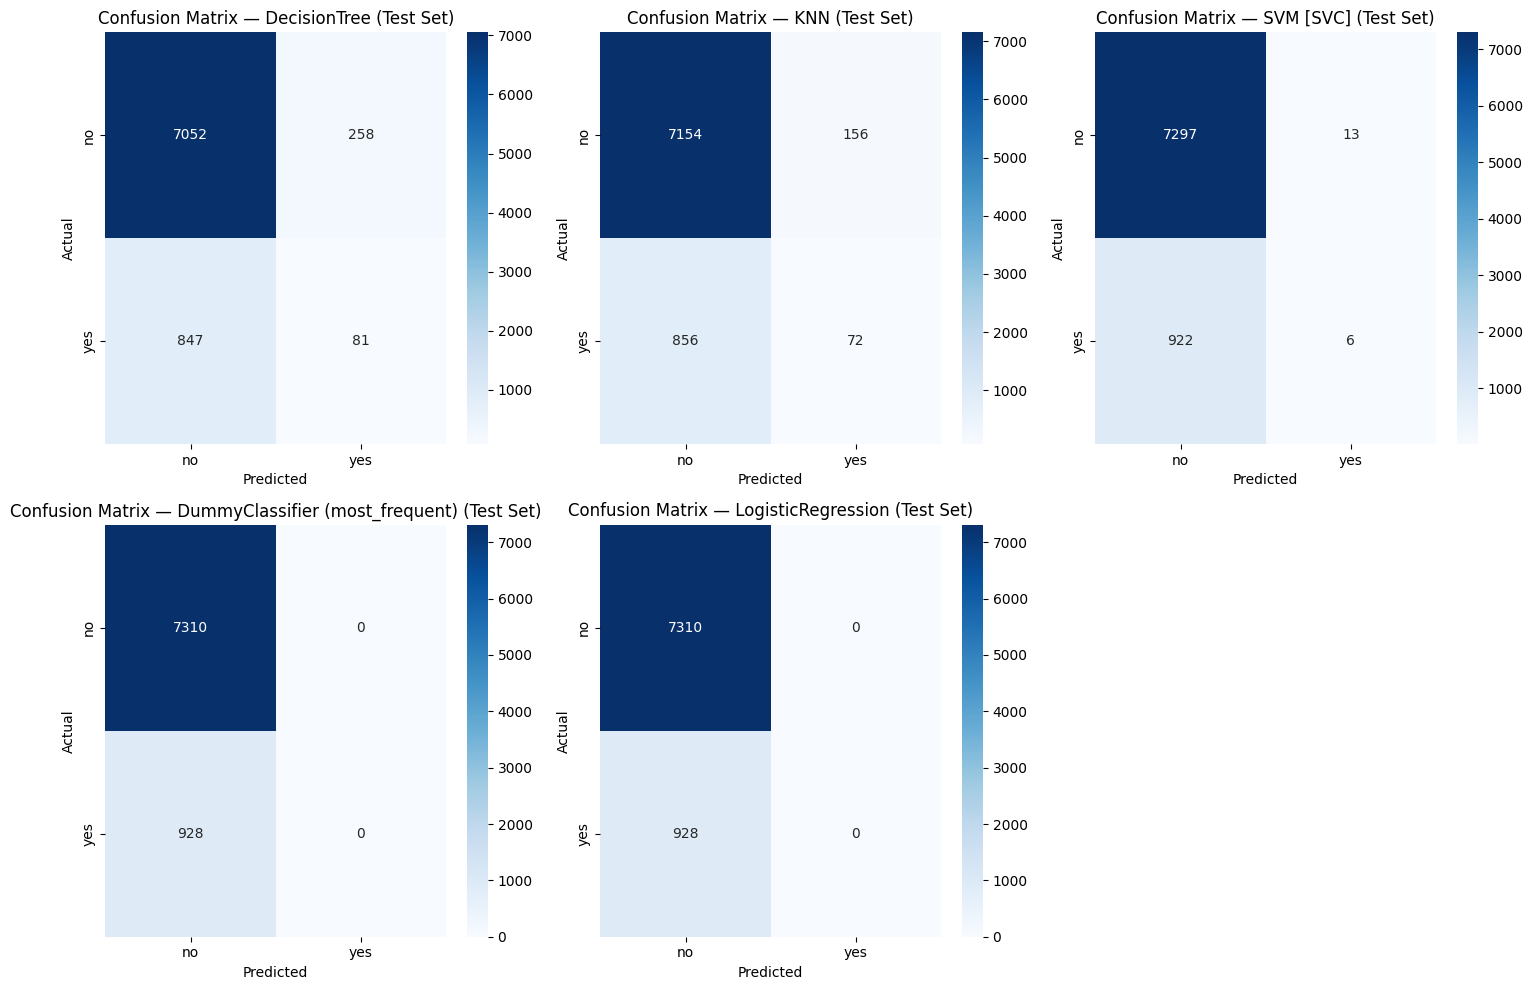

In [15]:
# Comparison table
comparison_df = pd.DataFrame([
    baseline_results,
    logreg_results,
    knn_results,
    dtree_results,
    svm_results,
])[['Model', 'Train Time', 'Predict Time', 'Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'CPU %', 'RAM %', 'RAM Used (GB)']]

# Set Model as index and sort
comparison_df = comparison_df.set_index('Model').sort_values(by=['Test F1', 'Test Recall', 'Test Accuracy'], ascending=False)

# Display comparison table
display(comparison_df)

# Subplot with heatmaps of all confusion matrices
try:
    # 1. Restore missing CMs from local variables for idempotency
    # This prevents empty plots if the dict was cleared but local vars exist.
    if 'confusion_matrices' not in globals():
        confusion_matrices = {}

    model_var_map = {
        'DummyClassifier (most_frequent)': 'baseline_test_cm',
        'LogisticRegression': 'logreg_test_cm',
        'KNN': 'knn_test_cm',
        'DecisionTree': 'dtree_test_cm',
        'SVM [SVC]': 'svm_test_cm'
    }

    for model_name, var_name in model_var_map.items():
        # Restore if missing from dict but present in local scope
        if model_name not in confusion_matrices and var_name in globals():
            confusion_matrices[model_name] = globals()[var_name]

    # 2. Retrieve sorted model names from the dataframe index to ensure plot order matches table order
    sorted_model_names = comparison_df.index.tolist()
    
    n_models = len(sorted_model_names)
    if n_models == 0:
        print("No confusion matrices available.")
    else:
        # Determine grid size (e.g. 3 columns)
        cols = 3
        rows = (n_models + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.ravel()

        for i, model_name in enumerate(sorted_model_names):
            cm = confusion_matrices.get(model_name)
            ax = axes[i]
            
            if cm is not None:
                sns.heatmap(
                    cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=['no', 'yes'],
                    yticklabels=['no', 'yes'],
                    ax=ax
                )
                ax.set_xlabel('Predicted')
                ax.set_ylabel('Actual')
                ax.set_title(f'Confusion Matrix — {model_name} (Test Set)')
            else:
                 # Placeholder if CM is missing for some reason
                ax.text(0.5, 0.5, 'Confusion Matrix Not Found', 
                        horizontalalignment='center', verticalalignment='center')
                ax.set_title(f"{model_name} (Missing CM)")

        # Hide unused subplots
        for j in range(n_models, len(axes)):
             fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
except NameError:
    print("confusion_matrices dictionary not defined. Please run previous model cells.")

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Changes to Improve and Tune Models

1. To align CV + scoring to the business objective I have decided to use F2 (beta=2) because in this busines context
false negatives (sales lost to call never made) are more costly than false positives (calls made not resulting in a sale).
Using F2 (beta=2) gives us a validation metric that prioritizes recall while still penalizing very low precision.

    Note: `f2_yes_scorer` and `cv` are declared in the global variables cell near the top of the notebook

    ![Confusion Matrix Performance Metric Visualization](images/cmpm.png)

    Using the above visualization as an aid, we can map the Confusion Matrix directly to business decisions:

    *   **Left Side (Predicted 'No' - Do Not Call):**
        *   **False Negatives (FN):** Missed opportunities. We failed to call a customer who would have bought. The cost here is the **lost margin** ($V$) from the foregone sale.
    *   **Right Side (Predicted 'Yes' - Call):**
        *   **True Positives (TP):** Successful sales. We gain the **margin** ($V$) minus the **contact cost** ($c$).
        *   **False Positives (FP):** Wasted effort. We incur the **contact cost** ($c$) without generating revenue.

    **Balancing Uplift, Margin, and Cost:**
    As defined via the profit impact formula at the end of the notebook in the Model Deployment section (Cell 53), our goal is to maximize the net value of our outreach. 
    *   Increasing **Uplift** (converting more customers) often requires a model with higher Recall (fewer FNs), which generates more "Call" recommendations.
    *   However, making more calls inevitably produces more False Positives, increasing aggregate **Cost**.
    
    Therefore, a model that maximizes uplift is only viable if the **Margin** ($V$) from the additional captured sales outweighs the **Cost** ($c$) of the extra unproductive calls. Additionally, since such a model increases the total volume of calls, we must ensure we have the labor capacity to handle the increased workload.

2. I will additionally switch to pipelines that leverage the existing ColumnTransformer preprocessing pipeline
with a classifier model and operate on split data that has not been preprocessed to avoid data leakage.

In [16]:
# Tune Logistic Regression with GridSearchCV using l1_ratio/C
# Note: avoid deprecated penalty grid

# If re-running, remove prior LogReg tuned results (avoid duplicates)
tuned_results = [r for r in tuned_results if r.get('Model') != 'LogReg (tuned)']
tuned_confusion_matrices.pop('LogReg (tuned)', None)

# Suppress any penalty deprecation warnings that might still surface from sklearn internals
warnings.filterwarnings(
    'ignore',
    message=".*'penalty' was deprecated.*",
    category=FutureWarning,
)

# Note: I am using solver='saga' below because 'saga' is designed to work well with large, sparse feature matrices
#       (e.g., one-hot encoded data) and it allows us to use the elasticnet penalty for F2 (beta2) scoring
# References:
# - LogisticRegression (solvers/penalties): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# - Logistic Regression user guide: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('classifier', LogisticRegression(max_iter=10000, solver='saga', random_state=RANDOM_STATE))
])

# Define GridSearch for tuning logreg_pipeline
logreg_gs = GridSearchCV(
    # max_iter increased to help convergence for iterative solvers on sparse, high-dimensional data.
    estimator=logreg_pipeline,
    param_grid={
        # C (Inverse Regularization Strength): Higher C (weaker regularization) allows the model to fit specific minority-class patterns (improving Recall).
        # Lower C (stronger regularization) forces generalization but might miss subtle minority signals.
        'classifier__C': [0.01, 0.1, 1, 10],
        # l1_ratio (ElasticNet): Balances L1 (feature selection, reducing noise that obscures minority signals) and L2 (handling multicollinearity).
        # Finding the right mix is key for maximizing F2.
        'classifier__l1_ratio': [0.0, 0.5, 1.0],
        # class_weight='balanced' increases the penalty for misclassifying the minority class ('yes'), directly improving Recall and F2.
        'classifier__class_weight': [None, 'balanced'],
    },
    scoring=f2_yes_scorer,
    cv=cv,
    n_jobs=int(DYNAMIC_N_JOBS),
    refit=True,
    verbose=0,
    return_train_score=True,
    error_score='raise',
)

# Tune logreg_pipeline with GridSearchCV keeping track of fit time
t0 = time.time()
logreg_gs.fit(X_train, y_train)
logreg_gs_fit_time = time.time() - t0

# Store and display best params and CV score for the tuned Logistic Regression model
best_logreg = logreg_gs.best_estimator_
print('Logistic Regression best params:', logreg_gs.best_params_)
print('Logistic Regression best CV F2(yes):', logreg_gs.best_score_)

# Perform estimations with tuned logreg_pipeline resulting from gridsearch keeping track of predition time
t0 = time.time()
logreg_gs_pred = best_logreg.predict(X_test)
logreg_gs_pred_time = time.time() - t0

# Display results
logreg_gs_row = evaluate_classifier('LogReg (tuned)', best_logreg, logreg_gs_pred)
logreg_gs_row['CV Best F2(yes)'] = logreg_gs.best_score_
logreg_gs_row['Best Params'] = logreg_gs.best_params_
logreg_gs_row['Fit Time (GridSearch)'] = logreg_gs_fit_time
logreg_gs_row['Predict Time (Test)'] = logreg_gs_pred_time
tuned_results.append(logreg_gs_row)

print(classification_report(y_test, logreg_gs_pred, zero_division=0))

Logistic Regression best params: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__l1_ratio': 1.0}
Logistic Regression best CV F2(yes): 0.4028640115190613
              precision    recall  f1-score   support

          no       0.93      0.54      0.68      7310
         yes       0.15      0.67      0.25       928

    accuracy                           0.55      8238
   macro avg       0.54      0.60      0.47      8238
weighted avg       0.84      0.55      0.63      8238

              precision    recall  f1-score   support

          no       0.93      0.54      0.68      7310
         yes       0.15      0.67      0.25       928

    accuracy                           0.55      8238
   macro avg       0.54      0.60      0.47      8238
weighted avg       0.84      0.55      0.63      8238



In [17]:
# Tune KNN model with GridSearchCV using n_neighbors, weights, and p (distance metric) parameters.
# Note: We are using integer targets for KNN training to avoid potential sklearn parallel backend issues with string labels.

y_train_knn = (y_train == 'yes').astype(int)
y_test_knn = (y_test == 'yes').astype(int)
f2_yes_int_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, zero_division=0)

# If re-running, remove prior KNN tuned results (avoid duplicates)
tuned_results = [r for r in tuned_results if r.get('Model') != 'KNN (tuned)']
tuned_confusion_matrices.pop('KNN (tuned)', None)

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('classifier', KNeighborsClassifier())
])

# Define GridSearch for tuning knn_pipeline
knn_gs = GridSearchCV(
    estimator=knn_pipeline,
    param_grid={
        # n_neighbors (k): Lower k captures local structure (good for small minority pockets but noisy).
        # Higher k smoothes decision boundaries (reduces variance but may wash out sparse minority signals).
        'classifier__n_neighbors': [5, 15, 25, 35],
        # weights: 'distance' gives closer neighbors more influence, helpful if minority samples are clustered tightly but sparsely.
        'classifier__weights': ['uniform', 'distance'],
        # p: Distance metric (1=Manhattan, 2=Euclidean). Different metrics may better capture the geometry of the minority class.
        'classifier__p': [1, 2],
    },
    scoring=f2_yes_int_scorer,
    cv=cv,
    n_jobs=DYNAMIC_N_JOBS,
    refit=True,
    verbose=0,
    return_train_score=True,
    error_score='raise',
 )

# Tune knn_pipeline with GridSearchCV keeping track of fit time
t0 = time.time()
knn_gs.fit(X_train, y_train_knn)
knn_gs_fit_time = time.time() - t0

# Store and display best params and CV score for the tuned KNN model
best_knn = knn_gs.best_estimator_
print('KNN best params:', knn_gs.best_params_)
print('KNN best CV F2(yes):', knn_gs.best_score_)

# Perform estimations with tuned knn_pipeline resulting from gridsearch keeping track of predition time
t0 = time.time()
knn_gs_pred_int = best_knn.predict(X_test)
knn_gs_pred_time = time.time() - t0

# Adapter to allow evaluate_classifier (which expects string labels) to work with our int-trained model
class KNNWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return np.where(self.model.predict(X) == 1, POS_LABEL, NEG_LABEL)
    def score(self, X, y):
        # Calculates accuracy against string labels
        return np.mean(self.predict(X) == y)

# Convert evaluation predictions to strings for the helper
knn_gs_pred_str = np.where(knn_gs_pred_int == 1, POS_LABEL, NEG_LABEL)

# Display results using evaluate_classifier helper with the wrapper
knn_gs_row = evaluate_classifier('KNN (tuned)', KNNWrapper(best_knn), knn_gs_pred_str)
knn_gs_row['CV Best F2(yes)'] = knn_gs.best_score_
knn_gs_row['Best Params'] = knn_gs.best_params_
knn_gs_row['Fit Time (GridSearch)'] = knn_gs_fit_time
knn_gs_row['Predict Time (Test)'] = knn_gs_pred_time
tuned_results.append(knn_gs_row)

print(classification_report(y_test, knn_gs_pred_str, zero_division=0))

KNN best params: {'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance'}
KNN best CV F2(yes): 0.1130455104549557
              precision    recall  f1-score   support

          no       0.89      0.97      0.93      7310
         yes       0.27      0.09      0.13       928

    accuracy                           0.87      8238
   macro avg       0.58      0.53      0.53      8238
weighted avg       0.82      0.87      0.84      8238



In [18]:
# Tune Decision Tree with GridSearchCV
# If re-running, remove prior Decision Tree tuned results (avoid duplicates)
tuned_results = [r for r in tuned_results if r.get('Model') != 'Decision Tree (tuned)']
tuned_confusion_matrices.pop('Decision Tree (tuned)', None)

dtree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Define GridSearch for tuning dtree_pipeline
dtree_gs = GridSearchCV(
    estimator=dtree_pipeline,
    param_grid={
        # max_depth: Deeper trees capture complex, specific patterns (vital for minority class recall), but risk overfitting noise.
        # Shallower trees generalize better but might miss detailed non-linear minority boundaries.
        'classifier__max_depth': [None, 5, 10, 20],
        # min_samples_split/leaf: Lower values allow the model to isolate specific, small groups of minority samples (improving Recall).
        # Higher values force generalization, potentially merging minority pockets into the majority background.
        'classifier__min_samples_split': [2, 20],
        'classifier__min_samples_leaf': [1, 10],
        # class_weight='balanced' increases the penalty for misclassifying the minority class ('yes'), directly improving Recall and F2.
        'classifier__class_weight': [None, 'balanced'],
    },
    scoring=f2_yes_scorer,
    cv=cv,
    n_jobs=int(DYNAMIC_N_JOBS),
    refit=True,
    verbose=0,
    return_train_score=True,
    error_score='raise',
)

# Tune dtree_pipeline with GridSearchCV keeping track of fit time
t0 = time.time()
dtree_gs.fit(X_train, y_train)
dtree_gs_fit_time = time.time() - t0

# Store and display best params and CV score for the tuned Decision Tree model
best_dtree = dtree_gs.best_estimator_
print('Decision Tree best params:', dtree_gs.best_params_)
print('Decision Tree best CV F2(yes):', dtree_gs.best_score_)

# Perform estimations with tuned dtree_pipeline resulting from gridsearch keeping track of predition time
t0 = time.time()
dtree_gs_pred = best_dtree.predict(X_test)
dtree_gs_pred_time = time.time() - t0

# Display results
dtree_gs_row = evaluate_classifier('Decision Tree (tuned)', best_dtree, dtree_gs_pred)
dtree_gs_row['CV Best F2(yes)'] = dtree_gs.best_score_
dtree_gs_row['Best Params'] = dtree_gs.best_params_
dtree_gs_row['Fit Time (GridSearch)'] = dtree_gs_fit_time
dtree_gs_row['Predict Time (Test)'] = dtree_gs_pred_time
tuned_results.append(dtree_gs_row)

print(classification_report(y_test, dtree_gs_pred, zero_division=0))

Decision Tree best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
Decision Tree best CV F2(yes): 0.38662693723387104
              precision    recall  f1-score   support

          no       0.92      0.72      0.81      7310
         yes       0.18      0.48      0.26       928

    accuracy                           0.70      8238
   macro avg       0.55      0.60      0.54      8238
weighted avg       0.83      0.70      0.75      8238

              precision    recall  f1-score   support

          no       0.92      0.72      0.81      7310
         yes       0.18      0.48      0.26       928

    accuracy                           0.70      8238
   macro avg       0.55      0.60      0.54      8238
weighted avg       0.83      0.70      0.75      8238



In [19]:
# Tune SVM (kernel comparison) with GridSearchCV
# If re-running, remove prior SVM tuned results (avoid duplicates)
tuned_results = [r for r in tuned_results if r.get('Model') != 'SVM (tuned)']
tuned_confusion_matrices.pop('SVM (tuned)', None)

# Optimization: Subsample training data for SVM GridSearch to reduce runtime (O(N^2) complexity)
print(f"Training data sample size set to {DYNAMIC_SVM_SAMPLE_SIZE*100:.1f}% random samples for SVM optimization")
if DYNAMIC_SVM_SAMPLE_SIZE < 1: # if sample size is less than 100%
    # Use train_test_split with shuffle=True to ensure a random sample is selected
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train, y_train, 
        train_size=DYNAMIC_SVM_SAMPLE_SIZE, 
        stratify=y_train, 
        random_state=RANDOM_STATE,
        shuffle=True 
    )
else:
    X_train_svm, y_train_svm = X_train, y_train

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('classifier', SVC(max_iter=10000))
])

# Define a manual class weight that is less aggressive than 'balanced' (= n_samples / (n_classes * np.bincount(y)))
# Balanced is approx ~4.5 for 'yes' (given ~11% positive rate).
# We try a milder weight (e.g., 3:1) to encourage recall without collapsing precision.
manual_weight = {POS_LABEL: 3, NEG_LABEL: 1}

# Define GridSearch for tuning svm_pipeline
# Optimization: Subsampling enables the inclusion of expensive kernels like 'poly' and 'sigmoid' without excessive runtime.
svm_gs = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=[
        {
            'classifier__kernel': ['linear'],
            # C (Inverse Regularization Strength): Higher C (weaker regularization) allows the model to fit specific minority-class patterns.
            # Lower C (stronger regularization) forces generalization.
            'classifier__C': [0.1, 1, 10],
            # class_weight='balanced' increases the penalty for misclassifying the minority class ('yes'), directly improving Recall and F2.
            'classifier__class_weight': [None, 'balanced', manual_weight],
        },
        {
            'classifier__kernel': ['rbf', 'sigmoid'],
            'classifier__C': [0.1, 1, 10],
            # gamma: Controls how far the influence of a single training example reaches.
            # High gamma (complex boundary) captures tight minority clusters; Low gamma (smooth boundary) generalizes more.
            'classifier__gamma': ['scale', 'auto'],
            'classifier__class_weight': [None, 'balanced', manual_weight],
        },
        {
            'classifier__kernel': ['poly'],
            'classifier__C': [0.1, 1, 10],
            # degree: Controls the complexity of the polynomial decision boundary.
            # Higher degrees can capture more intricate patterns but risk overfitting and significantly increase training time.
            'classifier__degree': [2, 3],
            'classifier__gamma': ['scale', 'auto'],
            'classifier__class_weight': [None, 'balanced', manual_weight],
        }
    ],
    scoring=f2_yes_scorer,
    cv=cv,
    n_jobs=int(DYNAMIC_N_JOBS),
    refit=True,
    verbose=0,
    return_train_score=True,
    error_score='raise',
 )

# Tune svm_pipeline with GridSearchCV keeping track of fit time
t0 = time.time()
svm_gs.fit(X_train_svm, y_train_svm) # Use subsampled data
svm_gs_fit_time = time.time() - t0

# Store and display best params and CV score for the tuned SVM model
best_svm = svm_gs.best_estimator_
print('SVM best params:', svm_gs.best_params_)
print('SVM best CV F2(yes):', svm_gs.best_score_)

# Perform estimations with tuned svm_pipeline resulting from gridsearch keeping track of predition time
# Note: predicting on the full test set is fast enough (O(N_test * N_sv)) and provides a comparable evaluation.
t0 = time.time()
svm_gs_pred = best_svm.predict(X_test)
svm_gs_pred_time = time.time() - t0

# Display results
svm_gs_row = evaluate_classifier('SVM (tuned)', best_svm, svm_gs_pred)
svm_gs_row['CV Best F2(yes)'] = svm_gs.best_score_
svm_gs_row['Best Params'] = svm_gs.best_params_
svm_gs_row['Fit Time (GridSearch)'] = svm_gs_fit_time
svm_gs_row['Predict Time (Test)'] = svm_gs_pred_time
tuned_results.append(svm_gs_row)

print(classification_report(y_test, svm_gs_pred, zero_division=0))

Training data sample size set to 10.0% random samples for SVM optimization
SVM best params: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
SVM best CV F2(yes): 0.38651683189753916
              precision    recall  f1-score   support

          no       0.92      0.62      0.74      7310
         yes       0.16      0.60      0.26       928

    accuracy                           0.61      8238
   macro avg       0.54      0.61      0.50      8238
weighted avg       0.84      0.61      0.68      8238



#### Geometric Model: Geometric K-Means (not covered in course material)

Background: A former colleague of mine recently shared this relatively new algorithm and I was curious to see how it performed
in a practical application relative to other algorithms, so while it is evaluated here, it will not be considered for deployment
or the final analysis at the end of this notebook.

The geometric model being evaluated uses geometric k-means, reference documentation can be found at the sites below:
- <https://arxiv.org/abs/2508.06353>
- <https://github.com/parichit/Geometric-k-means>
- <https://pypi.org/project/DataCentricKMeans/>

##### Methodology: Unsupervised Clustering for Supervised Classification

**Unsupervised vs. Supervised Learning:**
Unlike the other classifiers used in this notebook (Logistic Regression, KNN, SVC, Decision Trees), which are *supervised* learning algorithms that learn directly from labeled examples ($y$), K-Means is inherently an *unsupervised* clustering algorithm designed to find natural groupings in data ($X$) without reference to labels.

To adapt this unsupervised technique for our supervised classification task, we employ a **"Clustering-then-Labeling"** strategy:
1.  **Clustering:** The algorithm partitions the feature space into $k$ clusters based on geometric proximity.
2.  **Labeling:** Each resulting cluster is assigned a class label (e.g., 'yes' or 'no') based on the majority vote or purity of the training samples that fall within it.

This effectively turns the clustering algorithm into a classifier: a new sample is classified based on the label of the nearest cluster centroid.

**Implementation Details & Wrappers:**
The `DataCentricKMeans` library is a standalone C++ implementation optimized for geometric clustering. Because it does not conform to the standard Scikit-Learn API (`fit`/`predict`), we implemented a custom wrapper class, `GeometricKMeansClassifier` (see Helper Functions), to bridge the two.

Key integration steps handled by the wrapper include:
*   **Data Conversion:** The library requires input data as a CSV file path rather than in-memory arrays. The wrapper automatically handles the I/O overhead of writing the training data to a temporary CSV file before execution.
*   **Purity-based Labeling:** To address class imbalance, the wrapper implements a `purity_threshold`. Instead of a simple majority vote (which would almost always result in 'no' for every cluster due to the rarity of term deposits), a cluster can be labeled 'yes' if the proportion of positive samples exceeds a tunable threshold (e.g., 10%), drastically improving potential recall.

In [20]:
# Create Pipeline
geo_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    # Pre-seed parameters are just defaults; GridSearch will override them
    ('classifier', GeometricKMeansClassifier(seed=RANDOM_STATE))
])

# Define Hyperparameter Grid
# Note: Use 'purity_threshold' to solve "all predictions are 'no'" issue.
#       By lowering the required purity (e.g., to 0.1), even clusters with only 10% 'yes' 
#       can be labeled as 'yes', dramatically increasing Recall.
param_grid = {
    'classifier__n_clusters': [10, 20, 50, 100],  # More clusters = higher chance to find pure 'yes' pockets
    'classifier__max_iter': [100],
    'classifier__purity_threshold': [0.1, 0.15, 0.2, 0.3, 0.5], # 0.5 is standard majority vote, lower = aggressive recall
    'classifier__positive_label': ['yes'] # Required for purity logic
}

# Initialize GridSearchCV
# Uses 'f2_yes_scorer' to prioritize Recall.
geo_gs = GridSearchCV(
    estimator=geo_pipeline,
    param_grid=param_grid,
    scoring=f2_yes_scorer,
    cv=cv,
    n_jobs=int(DYNAMIC_N_JOBS),
    refit=True,
    verbose=0,
    return_train_score=True,
    error_score='raise'
)

# Fit the Model
if HAS_GEOKMEANS:
    print("Starting Grid Search for Geometric K-Means...")
    t0 = time.time()
    
    geo_gs.fit(X_train, y_train)
    geo_gs_fit_time = time.time() - t0
    
    best_geo = geo_gs.best_estimator_
    print('Geometric K-Means best params:', geo_gs.best_params_)
    print('Geometric K-Means best CV F2(yes):', geo_gs.best_score_)
    
    # Evaluate on Test Set
    t0 = time.time()
    geo_gs_pred = best_geo.predict(X_test)
    geo_gs_pred_time = time.time() - t0
    
    # Store Results
    # Clean up old results for idempotency (Prevents duplicates) BEFORE adding new ones
    current_model_name = 'Geometric K-Means (tuned)'
    tuned_results = [r for r in tuned_results if r['Model'] != current_model_name]
    tuned_confusion_matrices.pop(current_model_name, None)
    
    # evaluate_classifier will insert the new CM into tuned_confusion_matrices
    geo_gs_row = evaluate_classifier(current_model_name, best_geo, geo_gs_pred)
    geo_gs_row['CV Best F2(yes)'] = geo_gs.best_score_
    geo_gs_row['Best Params'] = geo_gs.best_params_
    geo_gs_row['Fit Time (GridSearch)'] = geo_gs_fit_time
    geo_gs_row['Predict Time (Test)'] = geo_gs_pred_time
    
    tuned_results.append(geo_gs_row)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, geo_gs_pred, zero_division=0))
else:
    print("Skipping Geometric K-Means execution: DataCentricKMeans library not available.")

Starting Grid Search for Geometric K-Means...
Geometric K-Means best params: {'classifier__max_iter': 100, 'classifier__n_clusters': 20, 'classifier__positive_label': 'yes', 'classifier__purity_threshold': 0.1}
Geometric K-Means best CV F2(yes): 0.40370152543601473

Classification Report (Test Set):
              precision    recall  f1-score   support

          no       0.94      0.39      0.55      7310
         yes       0.14      0.79      0.24       928

    accuracy                           0.44      8238
   macro avg       0.54      0.59      0.40      8238
weighted avg       0.85      0.44      0.52      8238



,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,Test F2,Confusion Matrix,CPU %,RAM %,RAM Used (GB),CV Best F2(yes),Best Params,Fit Time (GridSearch),Predict Time (Test)
Model,,,,,,,,,,,,,,
Geometric K-Means (tuned),0.440698,0.438213,0.141612,0.787716,0.240066,0.411877,"[[2879, 4431], [197, 731]]",6.9,23.1,3.54,0.403702,"{'classifier__max_iter': 100, 'classifier__n_c...",378.376619,0.039811
LogReg (tuned),0.558786,0.550619,0.154975,0.671336,0.251819,0.402871,"[[3913, 3397], [305, 623]]",6.9,20.0,3.06,0.402864,"{'classifier__C': 0.01, 'classifier__class_wei...",234.844586,0.011465
SVM (tuned),0.619211,0.613863,0.164832,0.596983,0.258335,0.391630,"[[4503, 2807], [374, 554]]",6.9,22.3,3.41,0.386517,"{'classifier__C': 0.1, 'classifier__class_weig...",56.421192,0.670095
Decision Tree (tuned),0.696965,0.695679,0.180494,0.480603,0.262430,0.360666,"[[5285, 2025], [482, 446]]",7.1,21.7,3.33,0.386627,"{'classifier__class_weight': 'balanced', 'clas...",27.064001,0.011609
KNN (tuned),0.915387,0.870721,0.273927,0.089440,0.134850,0.103362,"[[7090, 220], [845, 83]]",20.4,20.3,3.11,0.113046,"{'classifier__n_neighbors': 5, 'classifier__p'...",318.930953,1.814564


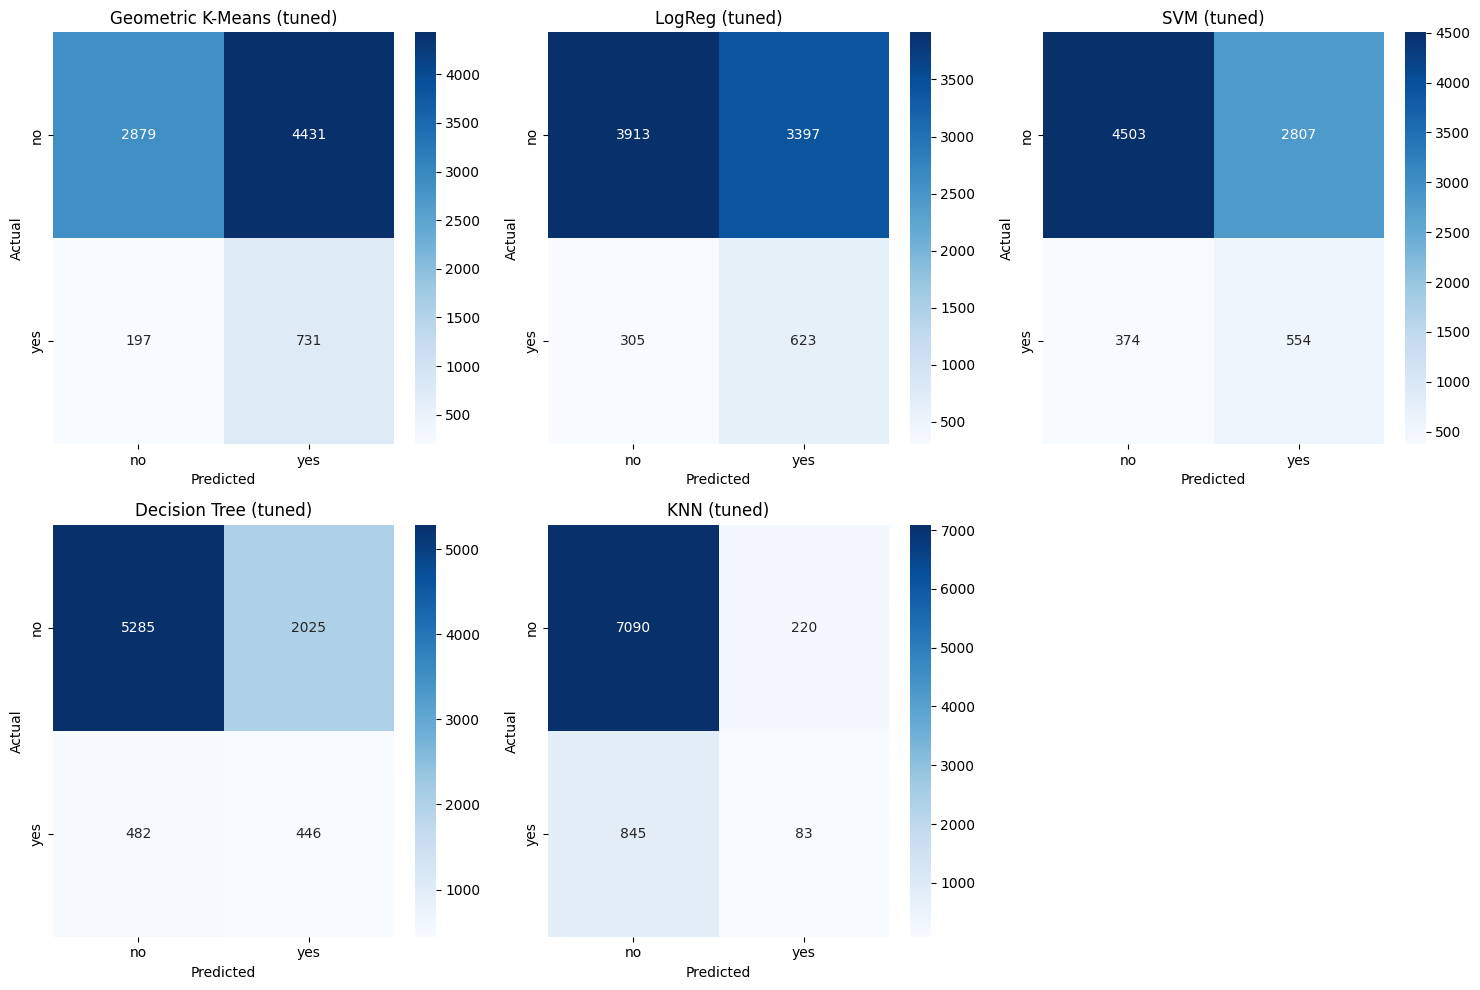

#### Feature Analysis: LogReg (tuned)

,Importance,Coefficient,Odds Ratio
Feature,,,
default=no,N/A,0.7841,2.1905
job=student,N/A,0.7705,2.1607
job=retired,N/A,0.6057,1.8324
marital=single,N/A,0.2954,1.3436
education=university.degree,N/A,0.1524,1.1647
age,N/A,0.1109,1.1173
job=admin.,N/A,0.0237,1.0239
,Importance,Coefficient,Odds Ratio
Feature,,,


#### Feature Analysis: KNN (tuned)

No direct coefficients or importance scores available for KNeighborsClassifier.


#### Feature Analysis: Decision Tree (tuned)

,Importance,Coefficient,Odds Ratio
Feature,,,
age,0.3828,N/A,N/A
default=no,0.3416,N/A,N/A
job=student,0.1334,N/A,N/A
education=university.degree,0.0903,N/A,N/A
job=blue-collar,0.0312,N/A,N/A
education=unknown,0.0086,N/A,N/A
job=management,0.0046,N/A,N/A
job=entrepreneur,0.0020,N/A,N/A
marital=married,0.0019,N/A,N/A


#### Feature Analysis: SVM (tuned)

No direct coefficients or importance scores available for SVC.


#### Feature Analysis: Geometric K-Means (tuned)

No direct coefficients or importance scores available for GeometricKMeansClassifier.


In [21]:
# Compare tuned models
tuned_comparison_df = pd.DataFrame(tuned_results)

# Deduplicate by Model column just in case re-runs occurred without clearing
if not tuned_comparison_df.empty and 'Model' in tuned_comparison_df.columns:
    tuned_comparison_df = tuned_comparison_df.drop_duplicates(subset=['Model'], keep='last')

tuned_comparison_df = tuned_comparison_df.set_index('Model').sort_values('Test F2', ascending=False)
display(tuned_comparison_df)

# Confusion matrices and feature importance (tuned models)
# Retrieve sorted model names from the dataframe index to ensure plot order matches table order
sorted_model_names = tuned_comparison_df.index.tolist()
n_models = len(sorted_model_names)

if n_models == 0:
    print('No tuned confusion matrices available yet. Run the GridSearchCV cells above first.')
else:
    # Determine grid size using a default of 3 columns
    cols = 3
    rows = (n_models + cols - 1) // cols
        
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    # Iterate through models in the order they appear in the comparison table
    for i, model_name in enumerate(sorted_model_names):
        cm = tuned_confusion_matrices.get(model_name)
        ax = axes[i]
        
        if cm is not None:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], ax=ax)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title(model_name)
        else:
            # Placeholder if CM is missing for some reason
            ax.text(0.5, 0.5, 'Confusion Matrix Not Found', 
                    horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"{model_name} (Missing CM)")

    # Hide unused subplots
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Feature Analysis for Tuned Models

# Dictionary of tuned models (verify they exist in local scope)
tuned_models = {
    'LogReg (tuned)': globals().get('best_logreg'),
    'KNN (tuned)': globals().get('best_knn'),
    'Decision Tree (tuned)': globals().get('best_dtree'),
    'SVM (tuned)': globals().get('best_svm'),
    'Geometric K-Means (tuned)': globals().get('best_geo')
}

# Run analysis for all tuned models
for name, model in tuned_models.items():
    if model is not None:
        analyze_model_features(name, model)
    else:
        print(f"Skipping feature analysis for {name}: Model not found (was it run?).")

#### Model Comparison Analysis and Summary

Because the target class (`y = 'yes'`) is relatively rare, **accuracy can be misleading**: a model can achieve high accuracy by predicting mostly (or only) “no”, yet have little value for identifying likely subscribers. For this reason, the grid searches above use **$F_2$ on the positive class** (“yes”), which weights recall more heavily than precision. This aligns with the stated business objective where **false negatives** (missing a likely subscriber) are more costly than false positives.

Key observations from the tuned confusion matrices and the tuned comparison table:

- **Logistic Regression (tuned)** achieves the strongest overall balance for this objective in these results: it attains the highest **Test $F_2$** by substantially increasing recall for “yes” (fewer false negatives), but at the cost of many **false positives** (predicting “yes” when actual is “no”).
- **Decision Tree (tuned)** improves recall compared to conservative baselines, but its **Test $F_2$** is lower than tuned Logistic Regression, indicating a weaker recall/precision tradeoff under the $F_2$ objective on this test split.
- **SVM [SVC] (tuned)** selected a configuration that effectively predicts “yes” for nearly everyone (confusion matrix shows essentially no predicted “no”). While this yields recall $\approx 1.0$ and can score well on recall-heavy metrics, it is typically **operationally unacceptable** because it overwhelms downstream outreach capacity with false positives and collapses overall accuracy.
- **KNN (tuned)** remains relatively conservative on the positive class in the final tuned results (low recall for “yes”), which leads to a low **Test $F_2$** despite high accuracy.

Overall, Problem 11 demonstrates that **changing the validation metric changes model behavior**. Optimizing $F_2(\text{yes})$ pushes models toward predicting more “yes” to capture positives (higher recall). The “best” model under $F_2$ should therefore be selected not only by the metric itself but also by whether its confusion-matrix tradeoffs are feasible given real marketing/outreach constraints.

References:
- [docs/CRISP-DM_overview/](docs/CRISP-DM_overview)
- Video covering experimentation in module 17 (A/B or clustered random controlled trials).

#### Interpreting Tuned Model Coefficients

Logistic Regression models the *log-odds* of subscription $P(y=\text{yes})$ as a linear function of the transformed features.

- **Sign:** a positive coefficient increases the predicted likelihood of `yes`; a negative coefficient decreases it.
- **Magnitude:** coefficients are on a log-odds scale; for a 1-unit change in a feature (after preprocessing), the odds multiply by $\exp(\beta)$.
- **Important preprocessing note:** `age` is **standardized** (via `StandardScaler`), so its coefficient corresponds to a **1 standard-deviation increase** in age, not a one-year increase.
- **One-hot encoding note:** categorical variables are one-hot encoded. Because no single category is explicitly treated as the reference category in this encoding, interpret category coefficients primarily by **comparing categories within the same feature** (e.g., odds ratio between categories $a$ and $b$ is $\exp(\beta_a - \beta_b)$).
- **Regularization note:** the tuned model used elastic-net with `l1_ratio=1.0` (L1), so many coefficients may be exactly 0; non-zero coefficients can be viewed as the subset of features retained by the model under the recall-prioritized objective ($F_2$).

Reference (Logistic Regression): [scikit-learn LogisticRegression docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

#### Model Selection

Based on the tuned model comparison using **Test $F_2(\text{yes})$** (recall-weighted to reduce false negatives) and the tuned confusion matrices, the recommended candidate model for deployment is:

- **Tuned Logistic Regression**

#### Model Selection Criteria and Rationale

Model selection is based on aligning with the business objective (false negatives are more costly than false positives) while also ensuring the model’s behavior is operationally feasible.

Criteria used:

- **Primary criterion: maximize $F_2(\text{yes})$ on held-out test data** to emphasize recall of likely subscribers while still penalizing extremely low precision.
- **Confusion-matrix sanity check:** prefer models that reduce false negatives without producing an unmanageably large number of false positives.
- **Operational feasibility:** the predicted-positive rate must be compatible with call-center/sales capacity; otherwise the model must be paired with a thresholding/ranking strategy.
- **Interpretability and maintainability:** Logistic Regression provides a straightforward baseline with stable training/prediction behavior and clear coefficients (useful for stakeholder communication).

Rationale:

- **Tuned Logistic Regression** achieved the highest **Test $F_2(\text{yes})$** among the tuned candidates, indicating the best alignment with the recall-prioritized objective of this evaluation.
- **Tuned SVC** is rejected despite strong recall because it degenerates into predicting nearly everyone as “yes”, which is not practical for deployment.
- **Tuned Decision Tree** offers an interpretable alternative but delivers a lower **Test $F_2$** than Logistic Regression in these results.
- **Tuned KNN** underperforms on recall and $F_2$ for the “yes” class.

Note: if business constraints require fewer false positives (limited outreach capacity), a possible next step would be to deploy Logistic Regression as a **ranker** (probability scoring) and choose an operating point (threshold/top-$k$) that meets capacity while monitoring recall impacts.

#### Model Deployment

To validate real-world impact and ensure the deployed model meets the business objective (reducing false negatives while remaining operationally feasible), deployment should include both **experimental evaluation** and **ongoing monitoring**.

- **Counterfactual evaluation (recommended):** use an experiment to estimate causal lift versus a control condition. This can be an **A/B test** or a **clustered randomized controlled trial** (e.g., randomize call centers, sales teams, or time blocks). This aligns with the need for counterfactual outcomes discussed in the course materials.
- **Define the operating policy:** because $F_2$ optimization tends to increase predicted positives, select an operating point that respects outreach capacity. Practical options include:
  - set a probability threshold for “yes”, or
  - contact the top-$k$ ranked customers by predicted probability.
- **Monitor post-deployment performance:** track confusion-matrix-derived metrics over time—especially **recall(yes)**, **precision(yes)**, and **$F_2(\text{yes})$**—as well as the predicted-positive rate (employee workload).
- **Data/Concept drift and retraining:** monitor shifts in input distributions and outcome rates; schedule periodic re-training and re-validation to maintain $F_2$ and recall performance.

An example of a clustered randomized control trial for this setting might include randomly choosing a subset of call centers (or sales-associate groups) to use the model-driven targeting strategy while others continue the current process, then compare subscription outcomes and resource usage between treatment and control groups.

To quantify the model’s impact on the organization’s bottom line in real dollars, the cleanest approach is to convert the experiment’s **incremental lift** into **incremental profit**:

Let

- $N_T, N_C$ = number of customers contacted (treatment, control)
- $\hat p_T, \hat p_C$ = observed subscription rates among those contacted (treatment, control)
- $V$ = average profit (or contribution margin / LTV) per incremental subscriber
- $c$ = variable cost per contact (call/email/etc.)
- $F$ = fixed deployment cost over the measurement period (integration, training, tooling)

Then an incremental-profit estimate is:

$$
\Delta \Pi
=
\Big(N_T(\hat p_T V - c) - F\Big)
-
\Big(N_C(\hat p_C V - c)\Big)
$$

If the experiment contacts the same number of customers in each group ($N_T=N_C=N$) and per-contact cost is the same, this simplifies to:

$$
\Delta \Pi \approx N(\hat p_T-\hat p_C)V - F
$$

This connects model deployment directly to business value: the term $\hat p_T-\hat p_C$ is the causal lift (counterfactual effect), $V$ translates lift into dollars, and $c$ and $F$ account for operational and implementation costs.

#### Summary of Findings (Nontechnical)

**What this model is for (in plain language):**
- The goal is to **prioritize which customers to contact** for a term-deposit offer by estimating who is *more likely* to subscribe (`y = yes`).
- Because missing a likely subscriber is considered more costly than contacting an unlikely one, the modeling and tuning emphasized **finding more of the “yes” cases** (higher recall).

**Bottom-line recommendation:**
- Use **Tuned Logistic Regression** as a **scoring model** that ranks customers by likelihood to subscribe.
- Operationally, contact either the **top-$k$** customers (ranked by predicted probability) or those above a chosen **probability threshold**—whichever best matches outreach capacity.

**Tradeoffs and operational risks to be aware of:**
- Prioritizing recall (via $F_2(\text{yes})$) typically increases the number of predicted “yes” customers. This means:
  - **Fewer missed opportunities** (fewer false negatives), but
  - **More false alarms** (more false positives), which can overload call-center/sales capacity and increase contact costs.
- Some tuned models (e.g., SVM in these results) can become **operationally unusable** by predicting “yes” for almost everyone. This is why confusion-matrix review and capacity constraints matter, not just a single metric.
- Coefficients help explain the model, but this is still a statistical model: relationships may shift over time (campaign design, macroeconomic changes, customer mix), so performance must be monitored.

**How to validate business value (not just model metrics):**
- Treat deployment as an experiment and measure **incremental lift** versus current practice (control), using an **A/B test** or **clustered randomized trial** (e.g., by call center, team, or time block).
- Track both **business outcomes** (subscriptions, incremental profit) and **operational outcomes** (contacts per day, acceptance rate, and customer experience signals).

**Monitoring after launch:**
- Monitor **precision(yes)**, **recall(yes)**, and **$F_2(\text{yes})$** over time, plus the **predicted-positive rate** (workload).
- Watch for **data drift** (input distributions changing) and **concept drift** (the relationship between features and subscription changing), then retrain/recalibrate thresholds as needed.

Reference (CRISP-DM Evaluation/Deployment framing): [docs/CRISP-DM_overview/](context/CRISP-DM_overview).

##### Questions